# Independence Tests Power over Increasing Sample Size

In [20]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.tools import indep_sim

sys.path.append(os.path.realpath('..'))

In [21]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:], n_colors=9)

In [22]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [59]:
SIMULATIONS = [
    "linear",
    "exponential",
    "cubic",
    "joint_normal",
    "step",
    "quadratic",
    "w_shaped",
    "spiral",
    "uncorrelated_bernoulli",
    "logarithmic",
    "fourth_root",
    "sin_four_pi",
    "sin_sixteen_pi",
    "square",
    "two_parabolas",
    "circle",
    "ellipse",
    "diamond",
    "multiplicative_noise",
    "multimodal_independence",
]

TESTS = [
#     CCA,
#     MGC,
#     RV,
    Dcorr,
    Hsic,
#     HHG,
]

In [51]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i, p=1, noise=True) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../fast/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

def fast_estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i, p=1, noise=True, auto=True) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../fast/vs_samplesize/{}_Fast_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [52]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
# )

In [53]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(fast_estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 18.3min finished


In [60]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = SIMULATIONS[count]
            
            for test in TESTS:
                power = np.genfromtxt('../fast/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
#                 hsic_power = np.genfromtxt('../fast/vs_samplesize/{}_Hsic.csv'.format(sim),
#                                       delimiter=',')
                
                colors = {
                    "MGC" : "#e41a1c",
                    "Dcorr" : "#377eb8",
                    "Hsic" : "#4daf4a",
                }
                test_name = test.__name__
                if test_name in ["Dcorr", "Hsic"]:
                    fast_power = np.genfromtxt('../fast/vs_samplesize/{}_Fast_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                
                if test_name == "MGC":
                    col.plot(SAMP_SIZES, power, color=colors[test_name], label=test_name, lw=2)
                elif test_name in ["Dcorr", "Hsic"]:
                    col.plot(SAMP_SIZES, power, color=colors[test_name], label=test_name, lw=4)
                    col.plot(SAMP_SIZES, fast_power, color=colors[test_name], label="Fast " + test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(SAMP_SIZES, power, label=test_name, lw=2)

                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../fast/figs/indep_power_sampsize.pdf', transparent=True, bbox_inches='tight')

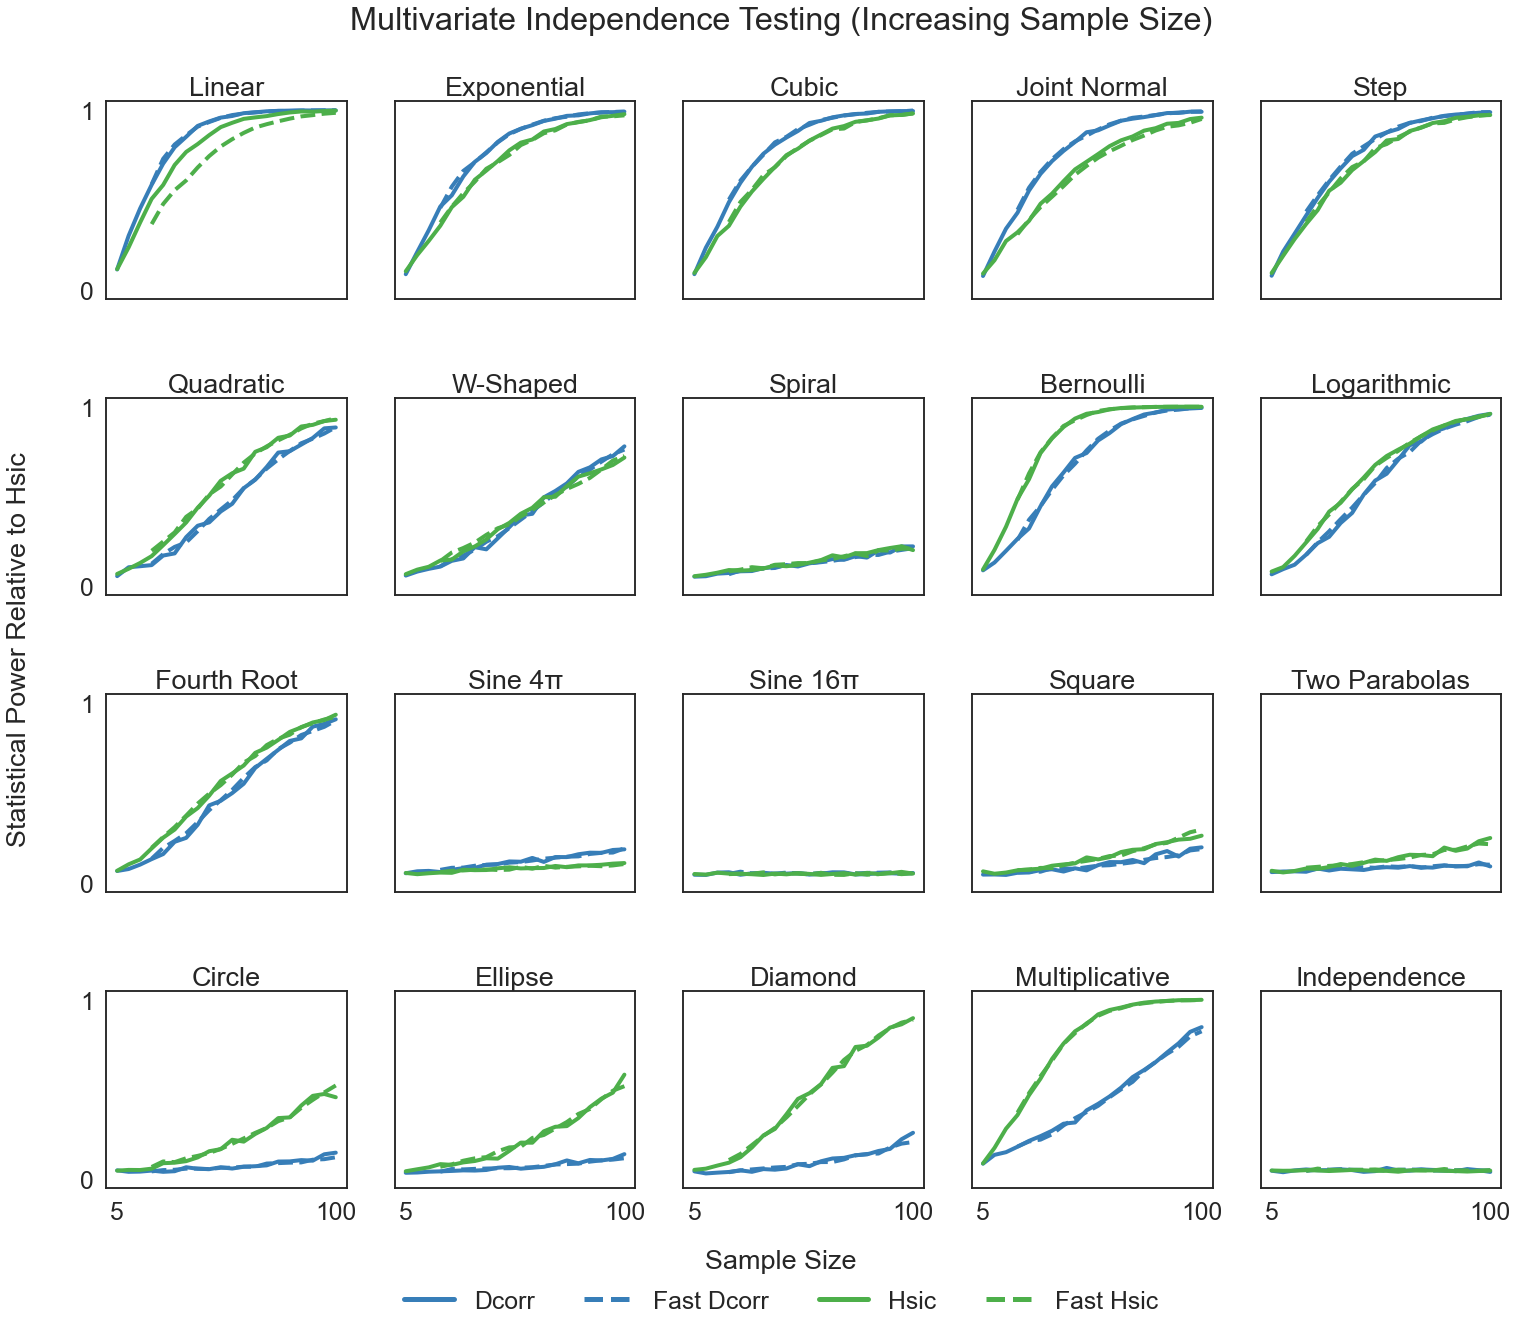

In [61]:
plot_power()